In [25]:
import os
import sys
import glob

import pickle
import itertools
import functools

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from contextlib import redirect_stdout
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from tensorflow import Session
import tensorflow.keras.backend as K
from tensorflow.keras import __version__
from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import top_k_categorical_accuracy, categorical_accuracy
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, Activation

%matplotlib inline

# show all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [26]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input as preprocess_input_Xception

from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_ResNet50

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_VGG16

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_input_InceptionV3

In [27]:
# os.chdir(path)
# os.getcwd()


### Functions to manage results

In [28]:
def plot_and_save_confusion_matrix(cm, classes, model_name,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                         ):
    """
    Plot and save confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        n = 'normalized'
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        n = 'counts'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.savefig('results/'+model_name+'_cm.png');
    plt.savefig('results/'+model_name+'_cm.jpg');
        
        
def save_predictions(filenames, predictions, unique_model_name):
    results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
    results.to_csv('results/'+unique_model_name+'.csv',index=False)
    
    
def save_confusion_matrix(cm, normalize, title, unique_model_name):
    plt.figure(figsize=(16,16))
    ax = plt.subplot()
    plot_and_save_confusion_matrix(cm, test_generator.class_indices.keys(), unique_model_name, 
                                   normalize=normalize, title=title);
    
    
def save_classification_report(report, unique_model_name):
    df = pd.DataFrame(report).transpose()
    df.to_excel('results/'+unique_model_name+'_cr'+'.xlsx')
    
    
def prediction_on_test(model, test_generator, unique_model_name):
    predictions = model.predict_generator(test_generator, steps=test_steps, verbose=1)

    predicted_class_indices=np.argmax(predictions,axis=1)
    y = (test_generator.class_indices)
    labels = dict((v,k) for k,v in y.items())
    predictions_labels = [labels[k] for k in predicted_class_indices]
    filenames=test_generator.filenames
    save_predictions(filenames, predictions_labels, unique_model_name)
    
    true_classes = test_generator.classes
    cm=confusion_matrix(true_classes, predicted_class_indices)
    save_confusion_matrix(cm=cm, normalize=True, title='Normalized confusion matrix', unique_model_name=unique_model_name)
    save_confusion_matrix(cm=cm, normalize=False, title='Confusion matrix', unique_model_name=unique_model_name)
    
    report = classification_report(true_classes, predicted_class_indices, output_dict=True)
    save_classification_report(report, unique_model_name)

    # calculate top-k accuracy
    top1 = 0.0
    top3 = 0.0
    top5 = 0.0    
    for i, l in enumerate(true_classes):
        class_prob = predictions[i]
        top_values = (-class_prob).argsort()[:5]
        if top_values[0] == l:
            top1 += 1.0
        if np.isin(np.array([l]), top_values[:3]):
            top3 += 1.0
        if np.isin(np.array([l]), top_values):
            top5 += 1.0

    top1_acc=top1/len(true_classes)
    top3_acc=top3/len(true_classes)
    top5_acc=top5/len(true_classes)    
            
    print("top1 acc", top1_acc)
    print("top3 acc", top3_acc)
    print("top5 acc", top5_acc)

    acu = accuracy_score(true_classes, predicted_class_indices)
    
    return acu, top1_acc, top3_acc, top5_acc # , Session.run(top3acu), Session.run(top5acu)

acc = []
val_acc = []
loss = []
val_loss = []


def reset_history():
    global acc
    global val_acc
    global loss
    global val_loss
    acc = []
    val_acc = []
    loss = []
    val_loss = []

def unpack_history(history):
    global acc
    global val_acc
    global loss
    global val_loss
    acc += history.history['acc']
    val_acc += history.history['val_acc']
    loss += history.history['loss']
    val_loss += history.history['val_loss']

def plot_history():
    epochs = np.arange(len(acc)) + 1
    
    fig = plt.figure(figsize=(12, 4))

    ax1 = fig.add_subplot(121)    
    ax1.plot(epochs, loss, c='g', label='Train')
    ax1.plot(epochs, val_loss, c='r', label='Valid')
    ax1.set_title('Loss')
    ax1.legend(loc='lower left');
    ax1.grid(True)
    
    ax2 = fig.add_subplot(122)    
    ax2.plot(epochs, acc, c='g', label='Train')
    ax2.plot(epochs, val_acc, c='r', label='Valid')
    ax2.set_title('Accuracy')
    ax2.grid(True)
        
    plt.show()    
    
    met_dic = {}
    met_dic['loss'] = loss
    met_dic['val_loss'] = val_loss
    met_dic['acc'] = acc
    met_dic['val_acc'] = val_acc

def display_and_save(history):
    unpack_history(history)
    plot_history()
    
    
def save_parameters_for_model(parameters_for_model, results_csv_filename):
    result_df = pd.DataFrame.from_dict(parameters_for_model)
    
    if not os.path.isfile(results_csv_filename):
        with open(results_csv_filename, 'w') as f:
            result_df.to_csv(f, header=True)
    else:         
        with open(results_csv_filename, 'a') as f:
            result_df.to_csv(f, header=False)


## Functions to use transfer learning

In [29]:
#define top-3 and top-5 accuracy
top3_acc = functools.partial(top_k_categorical_accuracy, k=3)
top3_acc.__name__ = 'top3_acc'

top5_acc = functools.partial(top_k_categorical_accuracy, k=5)
top5_acc.__name__ = 'top5_acc'


def get_nb_files(directory):
    """Get number of files by searching directory recursively"""
    if not os.path.exists(directory):
        return 0
    cnt = 0
    for r, dirs, files in os.walk(directory):
        for dr in dirs:
              cnt += len(glob.glob(os.path.join(r, dr + "/*")))
    return cnt

def add_new_last_layer(base_model, nb_classes):
    """Add last layer to the convnet
    Args:
    base_model: keras model excluding top
    nb_classes: # of classes

    Returns:
    new keras model with last layer
    """
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(nb_classes, activation='softmax')(x) #new softmax layer
    model = Model(inputs=base_model.input, outputs=predictions)
    return model


def setup_to_transfer_learn(model, args, lr):
    """Freeze all layers and compile the model"""
    
    for layer in model.layers:
        layer.trainable = False
    
#     import pandas as pd
#     pd.set_option('max_colwidth', -1)
#     layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
#     pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 
    
    model.layers[-1].trainable=True
    
    opt = Nadam(lr=lr)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', top3_acc, top5_acc])
    return model


def setup_to_finetune(model, args, not_trainable, lr):
    """Freeze all layers except the last not_frozen ones
    Args:
        model: keras model
        not_trainable: number of not trainable layers (default = 9, entire block 14)
        learning_rate: default 0.0001
    """
    
    for layer in model.layers[not_trainable:]:
        layer.trainable = True  
      
        opt = Nadam(lr=lr)
        model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', top3_acc, top5_acc])
    return model


def get_input_shape(model_name):
    if model_name == "VGG16" or model_name == "ResNet50":
        IM_WIDTH = 224
        IM_HEIGHT = IM_WIDTH
    else :
        IM_WIDTH = 299
        IM_HEIGHT = IM_WIDTH
    return IM_HEIGHT, IM_WIDTH


def get_unique_model_name(model_name, data_name):
    unique_model_name = datetime.now().strftime("%Y%m%d-%H%M%S") + '_' + model_name + data_name
    logdir='logs/scalars/'+data_name+'/' + unique_model_name
    tensorboard_callback = TensorBoard(log_dir=logdir)
    
    return unique_model_name, tensorboard_callback


def save_model_summary(model, unique_model_name, model_type):
    with open('results/' + 'summary_' + str(model_type) + '_' + str(unique_model_name), 'w') as f:
            with redirect_stdout(f):
                model.summary();

### Hyperparameters

In [30]:
class Args():
    def __init__(self, data_dir):
        self.train_dir = os.path.join(data_dir, 'train')
        self.val_dir = os.path.join(data_dir, 'valid')
        self.test_dir = os.path.join(data_dir,'test')        
        self.batch_size = 8
        self.output_model_file = './models/xception_e{}.hdf5'
        self.plot = True

In [33]:
# args = Args(os.path.join("C:\\", "Users", "jazzu", "cars"))
# data_name = 'cars'

args = Args(os.path.join("C:\\", "Users", "jazzu", "ISIC_2018", "data"))
data_name = 'isic'

In [34]:
os.path.exists(args.train_dir)

True

### Check data organization and set variables

In [40]:
nb_classes = len(os.listdir(os.path.join(args.train_dir)))
names_classes = [os.path.basename(c) for c in glob.glob(args.train_dir + "/*")]
print('Number of classes', nb_classes)
print('List of classes', names_classes, '\n')

nb_train_samples = get_nb_files(args.train_dir)
nb_val_samples = get_nb_files(args.val_dir)
nb_test_samples = get_nb_files(args.test_dir)

samples_dir = {'train': args.train_dir,
                'valid': args.val_dir,
                'test': args.test_dir}

samples_nb = {'train': nb_train_samples,
                'valid': nb_val_samples,
                'test': nb_test_samples}

d={}
df = pd.DataFrame(names_classes).set_index(0)
for sample_name, sample_dir in samples_dir.items():
#     print('\nNumber of ', sample_name, ' samples', samples_nb[sample_name], 'where:')
    for c in names_classes:
        nb_samples = len(os.listdir(os.path.join(sample_dir, c)))
        d[c] = nb_samples
#         print(c, ':', nb_samples)
    df[sample_name]=d.values()

df

train_steps = int(nb_train_samples/args.batch_size)
valid_steps = int(nb_val_samples/args.batch_size)
test_steps = int(nb_test_samples/args.batch_size)

print('\nNumber of steps per epoch', train_steps)
print('Number of validation steps', valid_steps)
print('Number of test steps', test_steps)

Number of classes 3
List of classes ['BKL', 'MEL', 'NV'] 



,train,valid,test
0,,,
BKL,769,165,165
MEL,779,167,167
NV,783,167,168



Number of steps per epoch 291
Number of validation steps 62
Number of test steps 62


### Data generators with augmentation

In [8]:
def create_generators(model_name):
    
    IM_HEIGHT, IM_WIDTH = get_input_shape(model_name)
    
    if model_name == 'VGG16':
        preprocess_input = preprocess_input_VGG16
    elif model_name == 'InceptionV3':
        preprocess_input = preprocess_input_InceptionV3
    elif model_name == 'Xception':
        preprocess_input = preprocess_input_Xception
    elif model_name == 'ResNet50':
        preprocess_input = preprocess_input_ResNet50
    else:
        preprocess_input = preprocess_input_Xception
        
    if data_name == "isic":
        train_datagen = ImageDataGenerator(
            preprocessing_function=preprocess_input,
            rescale=1./255,
            brightness_range = [0.75,1.25],
            horizontal_flip = True,
            vertical_flip=True,
            rotation_range = 30,
            width_shift_range=50,
            height_shift_range=50,            
            fill_mode='reflect'
        )
    elif data_name == "cars":
        train_datagen = ImageDataGenerator(
            preprocessing_function=preprocess_input,
            rescale=1./255,
            horizontal_flip = True,
            vertical_flip=True,
            width_shift_range=50,
            height_shift_range=50,
        )
        

    test_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rescale=1./255
    )

    train_generator = train_datagen.flow_from_directory(
        args.train_dir,
        target_size=(IM_WIDTH, IM_HEIGHT),
        batch_size=args.batch_size,
    )

    validation_generator = test_datagen.flow_from_directory(
        args.val_dir,
        target_size=(IM_WIDTH, IM_HEIGHT),
        batch_size=args.batch_size,
    )

    test_generator = test_datagen.flow_from_directory(
        args.test_dir,
        target_size=(IM_WIDTH, IM_HEIGHT),
        batch_size=args.batch_size,
        shuffle=False
    )
    
    return train_generator, validation_generator, test_generator

### Model

In [36]:
def get_model(model_name, base_model, set_weights):
    
    IM_HEIGHT, IM_WIDTH = get_input_shape(model_name)
    
    if not model_name == 'CNN':
        model = base_model(weights=set_weights, include_top=False, input_shape=(IM_HEIGHT, IM_WIDTH, 3))
        model = add_new_last_layer(model, nb_classes)        
    else:
        model = Sequential()
        
        model.add(Conv2D(64, (3, 3), padding='same',
                                 input_shape=(IM_HEIGHT, IM_WIDTH, 3)))
        model.add(Conv2D(32, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.4))
        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(Conv2D(32, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.4))
        model.add(Conv2D(32, (3, 3), padding='same'))
        model.add(Conv2D(16, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(Flatten())
        model.add(Dense(64))
        model.add(Activation('relu'))
        model.add(Dense(nb_classes, activation='softmax'))
        
    return model

### Transfer learning

In [13]:
# setup_to_transfer_learn(model, args, lr)
# save_model_summary(model)

In [23]:
params = {}

list_od_models = {
    'VGG16': VGG16,
    'Xception': Xception,
    'InceptionV3': InceptionV3,
    'ResNet50': ResNet50,
#     'CNN': Sequential()
}

# lr_list=[0.0005, 0.0001, 0.00005, 0.00001]
# lr_list = [0.001, 0.0001, 0.0005]
lr_list = [0.0001]

weights = ['imagenet', None]

frozens = {
    'VGG16': [11, 15],
    'Xception': [126, 46, 26], 
    'InceptionV3': [172, 249], 
    'ResNet50': [165, 155],
#     'CNN': []
}

for model, frozen_list in frozens.items():
    frozens[model] = [-1] + frozen_list + [0]
#     frozens[model] = frozen_list + [0]
#     frozens[model] = frozen_list
    
frozens

{'VGG16': [-1, 11, 15, 0],
 'Xception': [-1, 126, 46, 26, 0],
 'InceptionV3': [-1, 172, 249, 0],
 'ResNet50': [-1, 165, 155, 0]}

In [38]:
def training(model, train_generator, validation_generator, tensorboard_callback, epochs):

    history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_steps,
        epochs = epochs,
        validation_data = validation_generator,
        validation_steps = valid_steps,
        class_weight = None,
        callbacks=[tensorboard_callback]
    )

    return history

# Pretrained models

20190922-192246_Xceptionisic
Found 2331 images belonging to 3 classes.
Found 499 images belonging to 3 classes.
Found 500 images belonging to 3 classes.
Epoch 1/15
292/292 [==============================] - 125s 429ms/step - loss: 0.7936 - acc: 0.6456 - top3_acc: 1.0000 - top5_acc: 1.0000 - val_loss: 0.5860 - val_acc: 0.7595 - val_top3_acc: 1.0000 - val_top5_acc: 1.0000
Epoch 2/15
292/292 [==============================] - 118s 404ms/step - loss: 0.6254 - acc: 0.7353 - top3_acc: 1.0000 - top5_acc: 1.0000 - val_loss: 0.5515 - val_acc: 0.7796 - val_top3_acc: 1.0000 - val_top5_acc: 1.0000
Epoch 3/15
292/292 [==============================] - 118s 404ms/step - loss: 0.5317 - acc: 0.7812 - top3_acc: 1.0000 - top5_acc: 1.0000 - val_loss: 0.5622 - val_acc: 0.7475 - val_top3_acc: 1.0000 - val_top5_acc: 1.0000
Epoch 4/15
292/292 [==============================] - 146s 500ms/step - loss: 0.4528 - acc: 0.8134 - top3_acc: 1.0000 - top5_acc: 1.0000 - val_loss: 0.5811 - val_acc: 0.7675 - val_top3_ac

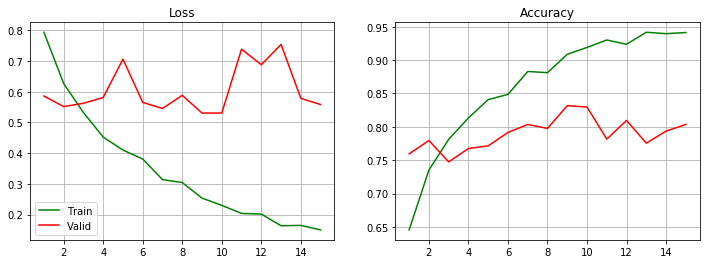

63/63 [==============================] - 9s 147ms/step
Normalized confusion matrix
Confusion matrix, without normalization
top1 acc 0.824
top3 acc 1.0
top5 acc 1.0


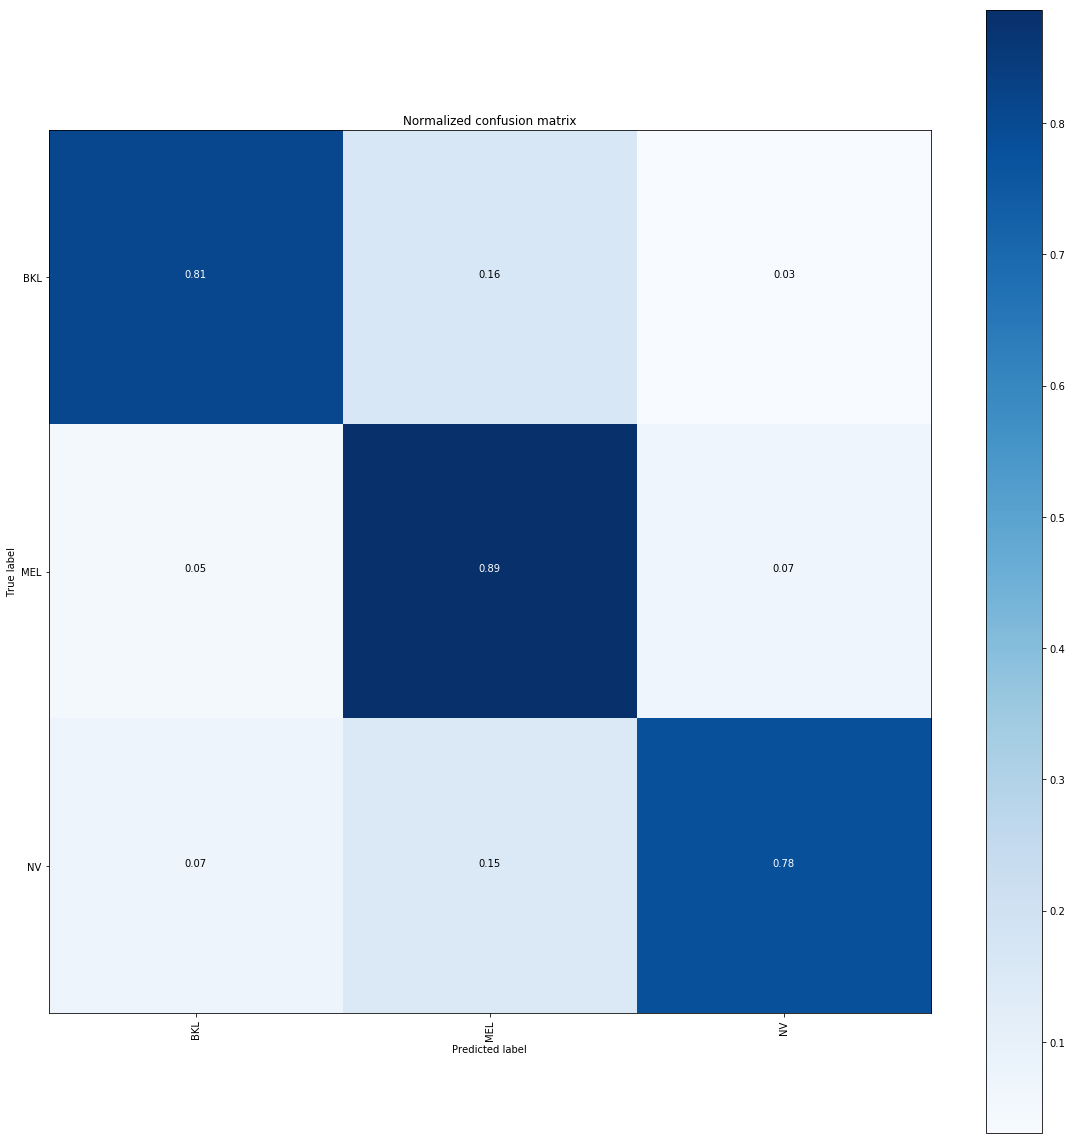

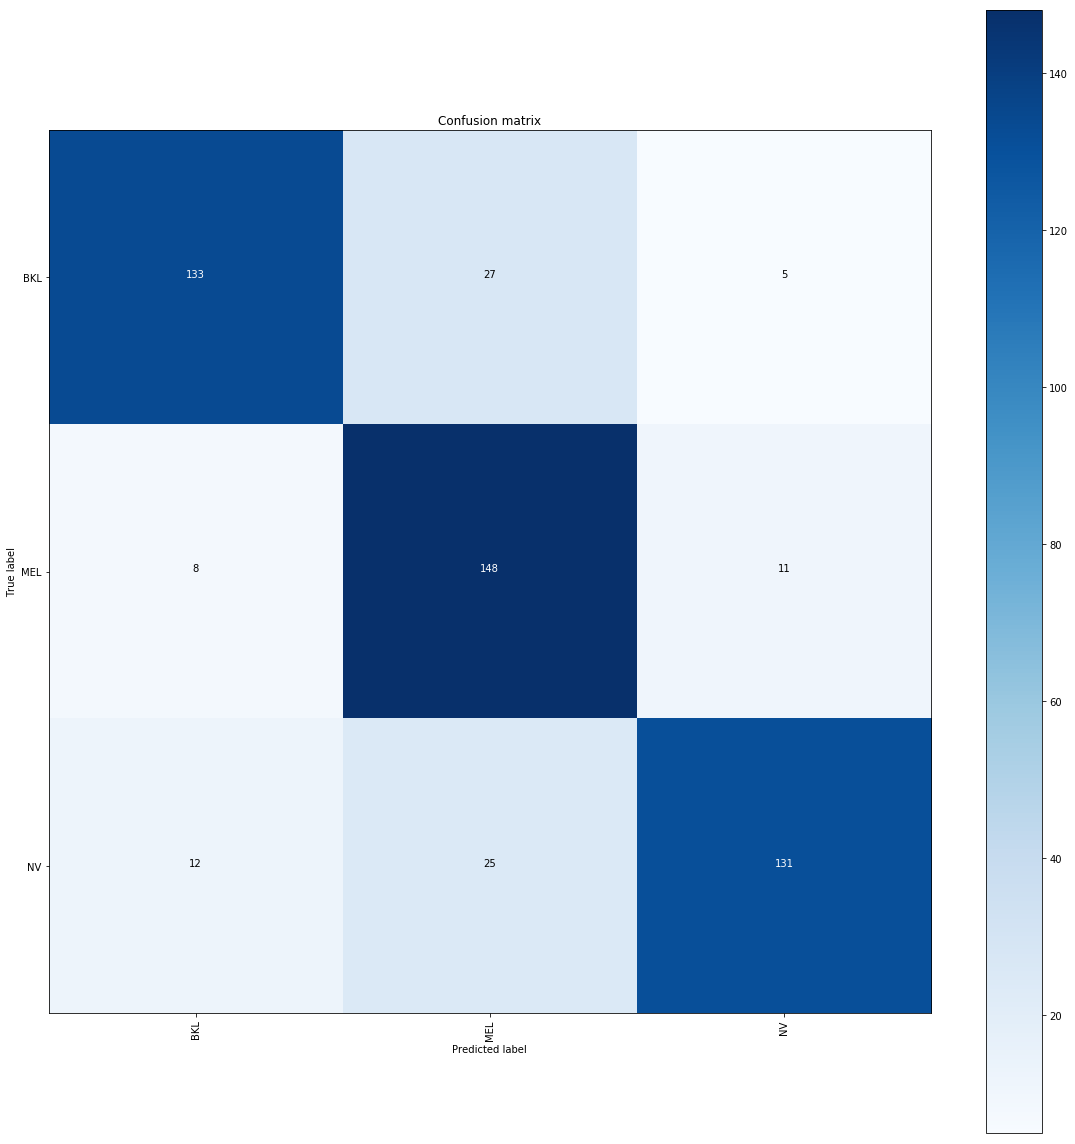

In [22]:
results_csv_filename = os.path.join("results", "RESULTS" + datetime.now().strftime("%Y%m%d-%H%M%S") + ".csv")

for weight in weights:
    params['weights'] = weight
    for model_name, base_model in list_od_models.items():
        model = get_model(model_name, base_model, weight)
        
        if weight:
            frozen_for_model = frozens[model_name]
        else:
            frozen_for_model = [0]
            
        for frozen in frozen_for_model:
            for lr in lr_list:    
                unique_model_name, tensorboard_callback = get_unique_model_name(model_name, data_name)
                print(unique_model_name)

                train_generator, validation_generator, test_generator = create_generators(model_name)

#                 model = setup_to_transfer_learn(model, args, lr)
#                 save_model_summary(model, unique_model_name, model_type='setup')
#                 history = training(model, train_generator, validation_generator, tensorboard_callback, epochs=5)
                
                model = setup_to_finetune(model, args, frozen, lr)
                save_model_summary(model, unique_model_name,  model_type='finetune')
                history = training(model, train_generator, validation_generator, tensorboard_callback, epochs=15)

                display_and_save(history)

                accuracy, top1acu, top3acu, top5acu = prediction_on_test(model, test_generator, unique_model_name)

                parameters_for_model_to_save = {
                    "model_name": [unique_model_name],
                    "learning_rate": [lr],
                    "accuracy": [accuracy],
                    "top1acu": [top1acu],
                    "top3acu": [top3acu],
                    "top5acu": [top5acu],
                    "frozen": [frozen],
                    "weight": [weight],
                    "params": [params]
                }

                save_parameters_for_model(parameters_for_model_to_save, results_csv_filename)
                
                reset_history()

# CNN

20190925-203428_CNNisic
Found 2331 images belonging to 3 classes.
Found 499 images belonging to 3 classes.
Found 500 images belonging to 3 classes.
Epoch 1/5
292/292 [==============================] - 93s 318ms/step - loss: 1.0689 - acc: 0.4084 - top3_acc: 1.0000 - top5_acc: 1.0000 - val_loss: 1.0064 - val_acc: 0.5030 - val_top3_acc: 1.0000 - val_top5_acc: 1.0000
Epoch 2/5
292/292 [==============================] - 87s 299ms/step - loss: 0.9864 - acc: 0.5242 - top3_acc: 1.0000 - top5_acc: 1.0000 - val_loss: 0.9518 - val_acc: 0.5431 - val_top3_acc: 1.0000 - val_top5_acc: 1.0000
Epoch 3/5
292/292 [==============================] - 87s 298ms/step - loss: 0.9485 - acc: 0.5586 - top3_acc: 1.0000 - top5_acc: 1.0000 - val_loss: 0.9537 - val_acc: 0.5230 - val_top3_acc: 1.0000 - val_top5_acc: 1.0000
Epoch 4/5
292/292 [==============================] - 87s 299ms/step - loss: 0.9108 - acc: 0.5719 - top3_acc: 1.0000 - top5_acc: 1.0000 - val_loss: 0.8823 - val_acc: 0.6112 - val_top3_acc: 1.0000 - v

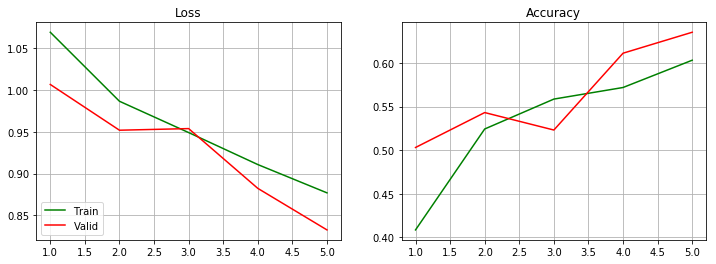

63/63 [==============================] - 7s 103ms/step
Normalized confusion matrix
Confusion matrix, without normalization
top1 acc 0.656
top3 acc 1.0
top5 acc 1.0


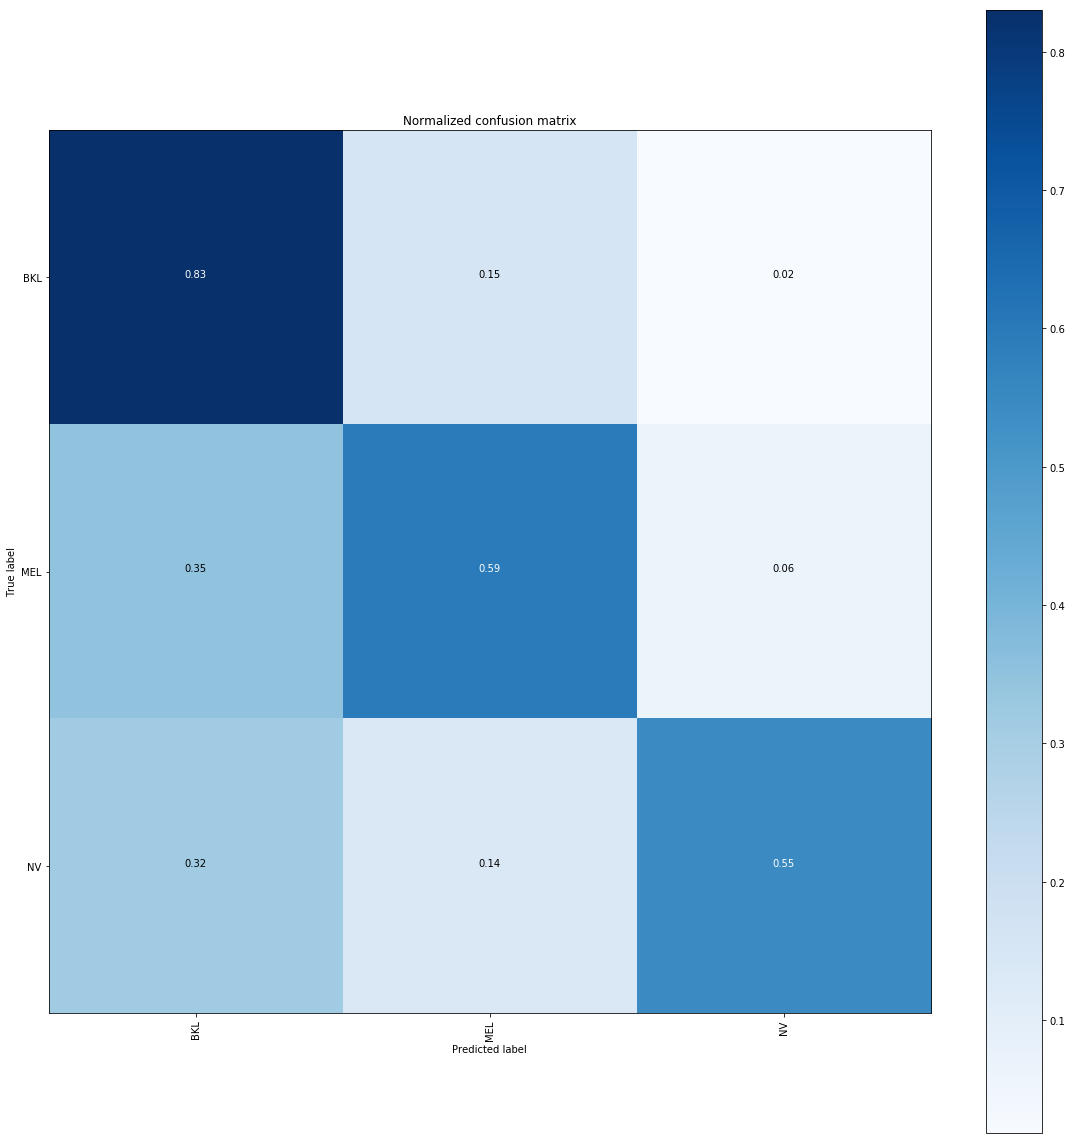

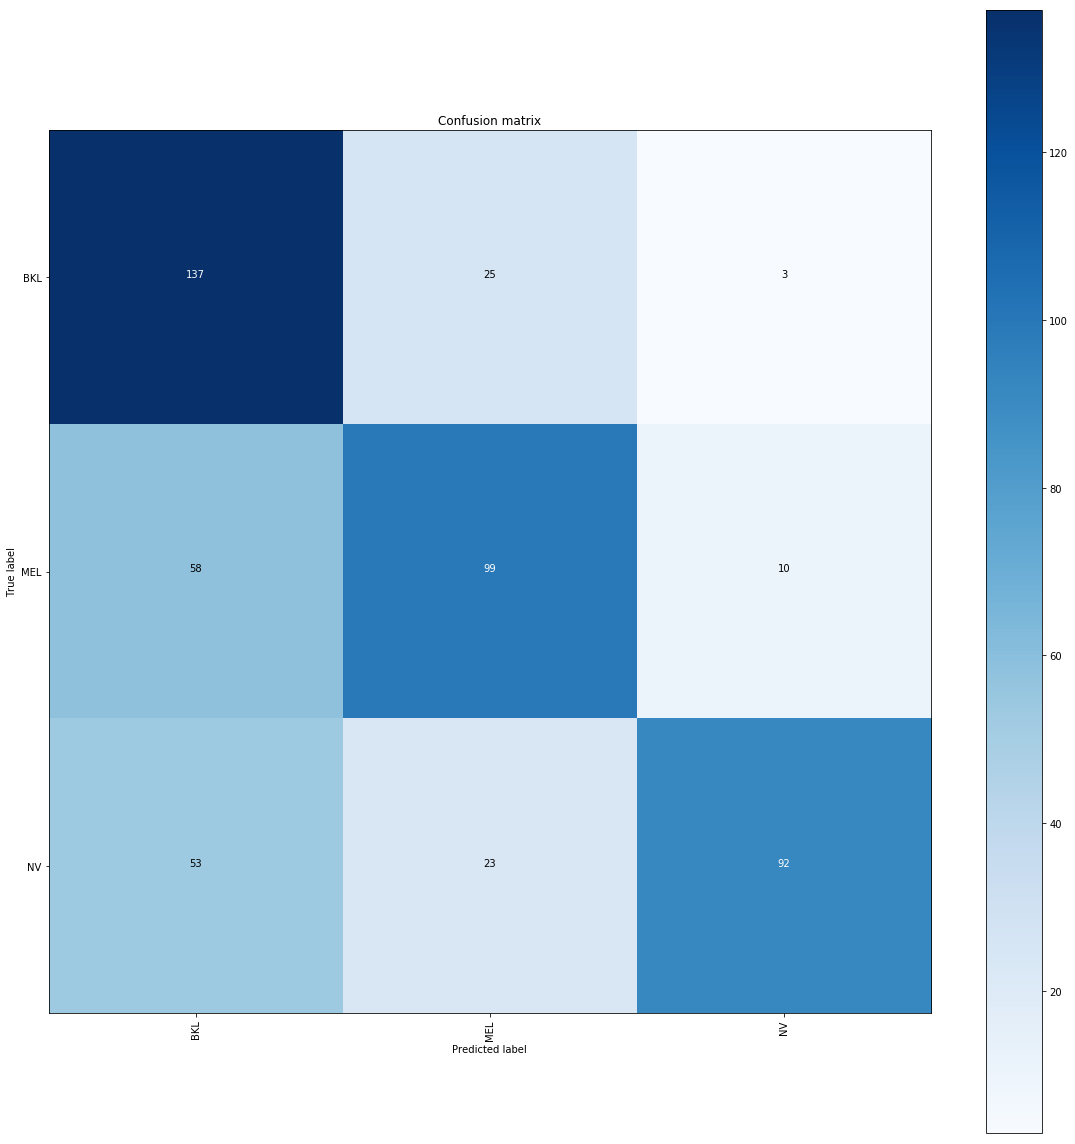

In [41]:
model_name = 'CNN'

results_csv_filename = os.path.join("results", "RESULTS" + datetime.now().strftime("%Y%m%d-%H%M%S") + ".csv")

for lr in lr_list:    
    model = get_model(model_name, None, None)
    unique_model_name, tensorboard_callback = get_unique_model_name(model_name, data_name)
    print(unique_model_name)

    train_generator, validation_generator, test_generator = create_generators(model_name)

    opt = Nadam(lr=lr)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', top3_acc, top5_acc])

    save_model_summary(model, unique_model_name, model_type='setup')
    history = training(model, train_generator, validation_generator, tensorboard_callback, epochs=5)

    display_and_save(history)

    accuracy, top1acu, top3acu, top5acu = prediction_on_test(model, test_generator, unique_model_name)

    parameters_for_model_to_save = {
        "model_name": [unique_model_name],
        "learning_rate": [lr],
        "accuracy": [accuracy],
        "top1acu": [top1acu],
        "top3acu": [top3acu],
        "top5acu": [top5acu],
        "params": [params]
    }

    save_parameters_for_model(parameters_for_model_to_save, results_csv_filename)

    reset_history()

# Save the final model

In [18]:
model.save(args.output_model_file.format(data_name))

# Load model and test

In [14]:
from tensorflow.keras.models import load_model
model = load_model(args.output_model_file.format('cars'), custom_objects={
        "top3_acc": top3_acc,
        "top5_acc": top5_acc
    })

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Found 1292 images belonging to 40 classes.
Found 279 images belonging to 40 classes.
Found 276 images belonging to 40 classes.

 Prediction: ['Chevrolet Corvette ZR1 2012'] 

 Probability: 0.65858597


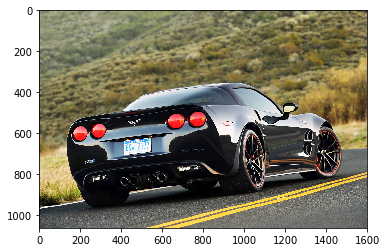

In [20]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage import transform

img = load_img('test2.jpg')
img_array = img_to_array(img)
img_array = preprocess_input_Xception(img_array)
img_array = transform.resize(img_array, (299, 299, 3))
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
predicted_class_indices = np.argmax(prediction,axis=1)

train_generator, validation_generator, test_generator = create_generators('Xception')
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
# predictions

from matplotlib import pyplot
print("\n Prediction:", predictions, '\n\n Probability: %s' % prediction.max())
pyplot.imshow(img);

In [16]:
prediction.max()

0.65858597

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import expand_dims
from matplotlib import pyplot

# augment_param = {'brightness_range':[0.2,2.2]} #DONE
# augment_param = {'zoom_range':[0.2,2.2]} #DONE
# augment_param = {'zoom_range':[0.2,0.8]} # cropping #DONE
# augment_param = {'rotation_range':135} #DONE
# augment_param = {'horizontal_flip':True}#DONE
# augment_param = {'vertical_flip':True} #DONE
# augment_param = {'width_shift_range':0.5} #DONE
# augment_param = {'height_shift_range':0.5} #DONE
# augment_param = {'zca_whitening':True}
# augment_param = {'preprocessing_function':get_random_eraser(p=0.8, v_l=0, v_h=0.4, pixel_level=False)}
# https://arxiv.org/pdf/1708.04896.pdf

# elastic_transform(koka, alpha = koka.shape[1] * 3, sigma = koka.shape[1] * 0.07)

augment_param = {'brightness_range':[0.6,1.35],
                'zoom_range':[0.9,0.95],
                'rotation_range':85, 
                'vertical_flip':True,
                 'width_shift_range':0.2,
                'preprocessing_function':get_random_eraser(p=0.4,pixel_level=True),
                'fill_mode': 'wrap'}

path = os.path.join("C:\\", "Users", "kinga", "cars", "train", "Bentley Continental GT Coupe 2007")
img = load_img('path/01935.jpg')
data = img_to_array(img)
samples = expand_dims(data, 0)

datagen = ImageDataGenerator(**augment_param)
it = datagen.flow(samples, batch_size=1)

for i in range(9):
    pyplot.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0].astype('uint8')
    pyplot.imshow(image)

pyplot.show()